## Project Control

This notebook should have been deployed in Watson Studio
    **but** unfortunately Watson Studio doesn't support interactive notebooks yet

Git Repos to be investigated:

* https://github.ibm.com/wiotp/monitoring-dashboard
* https://github.ibm.com/wiotp/analytics-service


### Github Analyzer

This notebook should have been deployed in Watson Studio
    **but** unfortunately Watson Studio doesn't support interactive notebooks yet

Git Repos to be investigated:

* https://github.ibm.com/wiotp/monitoring-dashboard
* https://github.ibm.com/wiotp/analytics-service


Influenced by IBM's Data and AI dev transformation group

<a href="https://github.ibm.com/DataandAI-dev-transformation/dev-transformation/blob/master/code-quality/defect_tracking.MD" target="_blank">DataandAI-dev-transformation - code quality defect tracking</a>

and more specifically the automatic component assigner for new defects [here](https://github.ibm.com/DataandAI-dev-transformation/defect_classification_ml_to_assign_component/blob/master/DefectClassifier_SGD_TFID_features-5.ipynb)

In [281]:
import csv
import requests
import collections
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [282]:
# custom functions - install with pip install git+https://github.com/sedgewickmm18/mmfunctions
from mmfunctions import gitanalyzer

In [283]:
# Repos and credentials to retrieve the data from
params = {}
params['REPO'] = 'wiotp/monitoring-dashboard'
params['REPO2'] = 'wiotp/analytics-service'
params['REPO_ID'] = 566611
params['REPO2_ID'] = 211664
params['ZENHUB_WORKSPACE'] = '5cd44ce4baded506ba8ddd5f'
params['GITHUB_TOKEN'] = 'ad7e5d3d34e79ac5d06210e74546c36b4bbc86ab'
params['ZENHUB_TOKEN'] = '814960f27921de182e39873816e4a54be9cdbb5000baa92d054e773949c1681e5e637c3bd30b54ad'
params['TRAVIS_TOKEN'] = '7B8mnG99oqNcHJgKKXMYVQ'
params['BASE_URL'] = 'https://github.ibm.com'

gitanalyzer.process_all(params)
# After extractoin store the data in cloud object store

In [284]:
# upload stuff for later use to COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
put monitoring-defects.csv s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in

upload: 'monitoring-defects.csv' -> 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv'  [1 of 1]
 734088 of 734088   100% in    3s   191.76 kB/s  done


In [285]:
# get it back from COS
!s3cmd --access_key "cc04444c99374c9e9589b8f85e931323" --secret_key "1a5062d937b09507a05b521a41b8baf6848c0cd6936e2864" \
--access_token "icny9QB770wS9p67JHCWb6C8ySJEn_3tmfjqct9qQhSY" --force --host s3.eu.cloud-object-storage.appdomain.cloud --host-bucket=s3.eu.cloud-object-storage.appdomain.cloud \
get s3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv wiotp-monitoring-dashboard-defects.csv

download: 's3://githubanalyzer-donotdelete-pr-b9xa3kxotzh5in/monitoring-defects.csv' -> 'wiotp-monitoring-dashboard-defects.csv'  [1 of 1]
 734088 of 734088   100% in    1s   437.28 kB/s  done


#### Example Data

Issue data from github and zenhub combined

In [286]:
defects_df = pd.read_csv('./wiotp-monitoring-dashboard-defects.csv') # parse_dates=['Created'])

## Remove the encoding prefix string
df=defects_df.replace('b\'','',regex=True).astype(object)
df=df.replace('b\"','',regex=True).astype(object)
df['Created'] = pd.to_datetime(df['Created'])
df['Updated'] = pd.to_datetime(df['Updated'])
df['Closed'] = pd.to_datetime(df['Closed'])

# Strip off outdated stuff
df = df[df['Pipeline'] != 'To Be Closed']
df.head(1)

,Title,Repo,Created,Updated,Closed,Origin,Assignee,Status,Milestone,Type,Component,Estimate,BusinessValue,Severity,Risk,Theme,Blocked,Pipeline,Labels
1017,Increase the catalog function name length.,wiotp/monitoring-dashboard,2020-05-05 07:35:07,2020-05-05 15:26:11,2020-05-05 15:26:11,Amritha-Herle,scottsd,closed,May 2020 - Sprint 15,Bug,NaN,NaN,0,4,2,NaN,NaN,NaN,"['MAS: Monitor', 'Sev 4', 'bug', 'ui']"


#### Our journey 

This is obviously a large wish list and not all of the metrics are equally important

![image.png](./images/Ayoa.png)

In [287]:
# Assign some risks random risks
df['Risk'] = np.random.choice([1,2,3], df['Risk'].values.shape[0], p=[0.2, 0.3, 0.5])
#df['Title'] = df['Title'][:5]
#df.head(5)

In [288]:
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import Layout, Button, ToggleButton, Box, Dropdown
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import Output

#w = widgets.IntSlider()
#display(w)

#### Split up issues by type and severity

In [289]:
df['Color'] = '#ffcc99'
#df[df['Type'] == 'Issue']['Color'] = '#ff9999'
#df[df['Type'] == 'Bug']['Color'] = '#66b3ff'
#df[df['Type'] == 'Epic']['Color'] = '#99ff99'

dfs = [df[df['Severity'] == 1], df[df['Severity'] == 2], df[df['Severity'] == 3], 
       df[df['Severity'] == 4], df]
dfssum = []

# prepare data
cnt = []
labels = []
explode = []
colors = []

for dfs_el in dfs:
    cnt_el = dfs_el.groupby('Type')['Title'].count()
    dfssum.append('Sum: ' + str(dfs_el.count()['Title']))
    labels.append(cnt_el.index)
    explode.append(np.zeros(cnt_el.size) + 0.02)
    #colors.append(cnt_el['Color'])
    cnt.append(cnt_el)
    
# define widget
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='23%')
dropdown = Dropdown(
    options=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev 1 to 4', 4), ('all', 11)],
    value=11,
    description='Severity:',
)
box = Box(children=[dropdown], layout=box_layout)
    
def f(severity):
    if severity > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,6))
        for i in [0,1,2,3,4]:
            ax[i].pie(cnt[i], explode=explode[i], labels=labels[i], autopct='%1.1f%%',
                      shadow=True, startangle=90)
            if i < 4:
                ax[i].set_title('Monitoring issues by Type\n   Severity: ' + str(i + 1))

            else:
                ax[i].set_title('Monitoring issues by Type\n   All severities')
            ax[i].text(-1.1,1,dfssum[i],ha='center',va='center',fontsize=12, 
                       bbox=dict(facecolor='beige', alpha=0.5))
    else:
        fig1, ax1 = plt.subplots()
        ax1.pie(cnt[severity], explode=explode[severity], labels=labels[severity], autopct='%1.1f%%',
                shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        if severity < 4:
            ax1.set_title('Monitoring issues by Type\n   Severity: ' + str(severity + 1))
        else:
            ax1.set_title('Monitoring issues by Type\n   All severities')
        ax1.text(-1.1,1,dfssum[severity],ha='center',va='center',fontsize=12, 
                       bbox=dict(facecolor='beige', alpha=0.5))

ws = interactive_output(f, {'severity': dropdown});
display(box, ws)

Box(children=(Dropdown(description='Severity:', index=5, options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev…

Output()

### Velocities

- Overall Velocity
- Defect Velocity (**implemented** - starting mid 2019)
- Customer satisfaction (**no data** not included as we have no data)
- Defect breakdown by severity (**no data** we have no severities in our defects)
- Value per sprint (**no data** value of epics or stories is not known)
- Percentage of test case coverage (**no data** - we do not track that)
- Customer Support Requests (**no data*)
- Trends (let's define what trends we need)
- NPS (**no data**)
- Build failures (need to get Travis data)
- Deployment failures (Jenkins ?)
- Technical Debts (**no data** we need a label)

#### Issue velocity

In [290]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


dfv = df.copy()
# replace NaT with now
dfv['Closed'] = dfv['Closed'].fillna(pd.Timestamp.now())
#dfv = dfv[dfv['Status'] == 'closed']

dfv = dfv[dfv['Created'] > StartWith]
dfv['Age_in_weeks'] = dfv['Closed'] - dfv['Created'] + pd.Timestamp('2020-01-01')
dfv = dfv[['Severity', 'Status', 'Type', 'Age_in_weeks']].set_index(['Type','Status'])



dfvs = [dfv[dfv['Severity'] == 1], dfv[dfv['Severity'] == 2],
        dfv[dfv['Severity'] == 3], dfv[dfv['Severity'] == 4], dfv]

cntv = []
for dfs_el in dfvs:
    cnt_el = dfs_el.groupby(['Status', 'Type', dfs_el['Age_in_weeks'].dt.week]).count().drop(columns='Age_in_weeks')
    cnt_el = cnt_el.reset_index().set_index('Age_in_weeks')
    #print (cnt_el)
    cntv.append(cnt_el)

StatusMap = [('open', 0), ('closed', 1), ('All',2)]
TypeMap = [('Issue', 0), ('Bug', 1), ('Epic',2), ('All', 3)]

IMAX = 11
emptydf = pd.DataFrame({'Age_in_weeks' : [IMAX], 'Severity': [0.001]}).set_index('Age_in_weeks')

def projection(sev, stat, typ):
    cntvp = []
    for cntv_el in cntv:
        if typ < 3:
            cntv_el = cntv_el[cntv_el['Type'] == TypeMap[typ][0]]   
        if stat < 2:
            cntv_el = cntv_el[cntv_el['Status'] == StatusMap[stat][0]]

        if cntv_el.index.size > 0 or cntv_el.index.max() < IMAX:
            cntv_el = cntv_el.append(emptydf)
            #print(cntv_el)
            

        cntvp.append(cntv_el)
    return cntvp
    
#print (cntv[0])
# define widget
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='65%')
dropdown = Dropdown(
    options=[('sev1', 0), ('sev2', 1), ('sev3',2), ('sev4',3), ('sev 1 to 4', 4), ('all', 11)],
    value=11,
    description='Severity:',
)
dropdown2 = Dropdown(
    options=StatusMap,
    value=1,
    description='Status:',
)
dropdown3 = Dropdown(
    options=TypeMap,
    value=3,
    description='Type:',
)
box = Box(children=[dropdown,dropdown2, dropdown3], layout=box_layout)

def f(severity, status, Type):
    #df_vel = df_velocity.copy()
    cntvp = projection(severity, status, Type)
    if severity > 10:
        fig, ax = plt.subplots(1, 5, figsize=(20,3))
        for i in [0,1,2,3,4]:
            ax[i].bar(cntvp[i].index, cntvp[i]['Severity'].values)
            if i < 4:
                ax[i].set_title('Monitoring issues aging\n   Severity: ' + str(i + 1))
            else:
                ax[i].set_title('Monitoring issues aging\n   All severities')
            ax[i].set_xlabel('Age in weeks')
    else:
        fig1, ax1 = plt.subplots(figsize=(7,3))
        ax1.bar(cntvp[severity].index, cntvp[severity]['Severity'].values)
        if severity < 4:
            ax1.set_title('Monitoring issues aging\n   Severity: ' + str(severity + 1))
        else:
            ax1.set_title('Monitoring issues aging\n   All severities')
        ax1.set_xlabel('Age in weeks')

ws = interactive_output(f, {'severity': dropdown, 'status': dropdown2, 'Type': dropdown3});
display(box, ws)

Box(children=(Dropdown(description='Severity:', index=5, options=(('sev1', 0), ('sev2', 1), ('sev3', 2), ('sev…

Output()

#### Open epics - risks vs value

Text(0.5, 1.0, 'Heatmap of open Epics\n by value and risk')

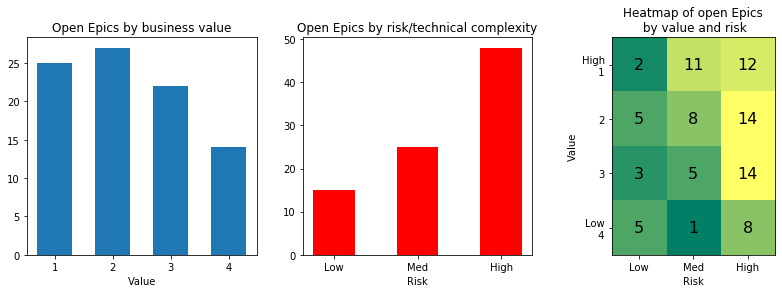

In [291]:
# defect velocity since mid 2019
StartWith = '2019-06-30'


df_val = df.copy()
df_val = df_val[df_val['BusinessValue'] > 0]
df_val['Risk'] += 1
df_val = df_val[df_val['Status'] == 'open'][['BusinessValue','Risk', 'Title']]
fig, ax = plt.subplots(1, 3, figsize=(14,4))
val_el = df_val.groupby(df_val['BusinessValue']).count()
risk_el = df_val.groupby(df_val['Risk']).count()
valrisk_el = df_val.groupby(['BusinessValue','Risk']).size()
valrisk_grid = valrisk_el.unstack().to_numpy()

ax[0].bar(val_el.index, val_el['Title'].values, width=0.6)
ax[0].set_title('Open Epics by business value')
ax[0].set_xlabel('Value')
ax[0].set_xticks([1,2,3,4])
#ax[1].set_xticklabels(['Low','Med','High'])


ax[1].bar(risk_el.index, risk_el['Title'].values, color='red', width=0.5)
ax[1].set_title('Open Epics by risk/technical complexity')
ax[1].set_xlabel('Risk')
ax[1].set_xticks([2,3,4])
ax[1].set_xticklabels(['Low','Med','High'])

ax[2].imshow(valrisk_grid, interpolation ='none', cmap='summer')
for (j,i),label in np.ndenumerate(valrisk_grid):
    if np.isnan(label):
        label = '0'
    else:
        label = int(label)
    ax[2].text(i,j,label,ha='center',va='center',fontsize=16)

ax[2].set_xlabel('Risk')
ax[2].set_xticks([0,1,2])
ax[2].set_xticklabels(['Low','Med','High'])
ax[2].set_ylabel('Value')
ax[2].set_yticks([0,1,2,3])
ax[2].set_yticklabels(['High\n 1',2,3,'Low\n 4'])
#ax[2].set_yticks([1,2,3,4,5])
ax[2].set_title('Heatmap of open Epics\n by value and risk')


### Initiatives, Epics, Stories

- Epics per Initiatives (not 
- Initiative completion by percentage
- Percentage of Epics completed
- Percentage of stories completed by sprint vs what was committed
- Defects per story
- End to end start to completion average

In [292]:
# Open vs closed epics

def f(Date):
    df_epics = df[df['Type'] == 'Epic']   
    df_epics = df_epics[df_epics['Created'] > Date]
    df_epics = df_epics[['Status', 'Type']]
    length = 20 * df_epics.index.size / 200
    df_epics.groupby(df_epics['Status']).count().plot(figsize=(length,2), kind='barh', legend=False)
    plt.title('Epics by completion \n created after ' + Date)

interact(f, Date=[('Jul 2019', '2019-06-30'), ('Oct 2019', '2019-09-30'), ('Jan 2020', '2019-12-31'), 
                  ('Feb 2020','2020-01-31'), ('Mar 2020', '2020-02-28'), ('Apr 2020','2020-03-31')])

interactive(children=(Dropdown(description='Date', options=(('Jul 2019', '2019-06-30'), ('Oct 2019', '2019-09-…

<function __main__.f>

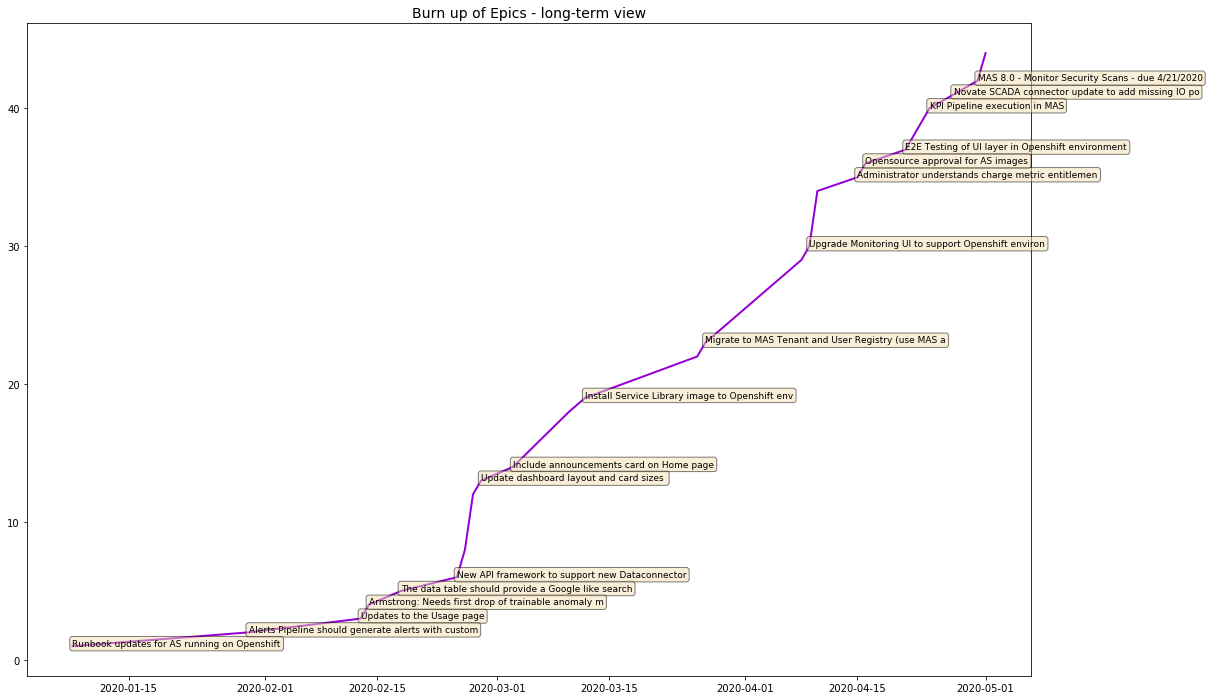

In [293]:
# Burnup
StartDate = '2020-01-01' # start with sprint 7
Type = 2 # only Epics

dfb = df.copy()

dfb = dfb[dfb['Created'] > StartDate]
dfb['Closed'] = dfb['Closed'].fillna(pd.Timestamp('2030-01-01'))
#dfb = dfb.set_index(['Closed'])

dfb = dfb[dfb.Type == 'Epic']
dfb['Closed'] = dfb['Closed'].dt.round('1d')

s = pd.to_datetime(dfb['Closed'])
dfc = s.groupby(s.dt.floor('d')).size().reset_index(name='count').set_index('Closed')
dfc['cumsum'] = dfc['count'].cumsum()

dfd = dfb[dfb['Closed'] < '2030-01-01'].set_index(['Closed'])
#print (dfd.index)
fig, ax = plt.subplots(1, 1, figsize=(18, 12), squeeze=False)
# ignore last value of epics still open
ax[0,0].plot(dfc[:-1].index, dfc['cumsum'][:-1].values, lw=2, color='darkviolet')
ax[0,0].set_title('Burn up of Epics - long-term view', fontsize=14)

boxprops = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for date_closed in dfd.index:
    try:
        ax[0,0].text(date_closed, dfc.loc[date_closed,:]['cumsum'], 
                     dfd.loc[date_closed,:]['Title'][:50], fontsize=9, zorder=10, bbox = boxprops)
    except Exception:
        pass



#### Next steps

- Aggregate data over smaller time spans such as **sprints** to get insights in velocity and completion rate
- Pull in data from travis and jenkins to include build process quality metrics


In [302]:
SprintMap = [('Release 2 Sprint 1', 1), ('Release 2 Sprint 2', 2),
             ('Release 2 Sprint 3', 3), ('Release 2 Sprint 4', 4),
             ('Release 2 Sprint 5', 5), ('Release 2 Sprint 6', 6),
             ('Release 2 Sprint 7', 7), ('Release 2 Sprint 8', 8),
             ('Release 2 Sprint 9', 9), ('Release 2 Sprint 10', 10),
             ('March 2020 Sprint 11', 11), ('March 2020 Sprint 12', 12),
             ('April 2020 Sprint 13', 13), ('April 2020 Sprint 14', 14),
             ('May 2020 - Sprint 15', 15), ('May 2020 - Sprint 16', 16),
             ('May 2020 - Sprint 17', 17)]
DateMap = [('2019-09-26', '2019-10-15'), ('2019-10-16', '2019-10-24'),  # sprints 1,2
           ('2019-10-25', '2019-11-07'), ('2019-11-08', '2019-11-22'),
           ('2019-11-23', '2019-12-12'), ('2019-12-13', '2020-01-09'),  # sprints 5,6
           ('2020-01-10', '2020-01-16'), ('2020-01-17', '2020-02-05'),
           ('2020-02-06', '2020-02-13'), ('2020-02-14', '2020-02-27'),  # sprints 9,10
           ('2020-02-28', '2020-03-12'), ('2020-03-13', '2020-03-25'),
           ('2020-03-26', '2020-04-08'), ('2020-04-09', '2020-04-22'),  # sprints april
           ('2020-04-23', '2020-05-06'), ('2020-05-07', '2020-05-20'),
           ('2020-05-21', '2020-06-02')]  # sprint 17

TypeMap = [('Issue', 0), ('Bug', 1), ('Epic',2), ('All', 3)]

box_layoutS = Layout(display='flex', flex_flow='row', align_items='stretch', border='solid', width='45%')
dropsprint = Dropdown(
    options=SprintMap,
    value=14,
    description='Sprint:',
)
droptype = Dropdown(
    options=TypeMap,
    value=1,
    description='Type:',
)
boxS = Box(children=[dropsprint, droptype], layout=box_layoutS)




def f_sprint(Sprint, Type):
    # get all stories of given type closed in this sprint 
    if Type != 3:
        df_sprint = df[df['Type'] == TypeMap[Type][0]]
    else:
        df_sprint = df.copy()
    
    print (Sprint)
    # Sprint start is in the past - use closed date
    #if pd.Timestamp(DateMap[Sprint][0]) < dt.datetime.now():
    #    df_sprint = df_sprint[DateMap[Sprint][0]<= df_sprint['Closed']]
    #    df_sprint = df_sprint[df_sprint['Closed'] <= DateMap[Sprint][1]]
    #else: # use planned date
    df_sprint = df_sprint[df_sprint['Milestone'] == SprintMap[Sprint-1][0]]
    #print (df_sprint[['Title','Closed','Milestone']])
    df_sprint['Closed'] = df_sprint['Closed'].fillna(pd.Timestamp('2030-01-01'))
    
    df_sprint['Sized'] = pd.isna(df_sprint['Estimate'].values)   
    df_sizes = df_sprint.groupby(df_sprint['Sized']).count()    
    df_value = df_sprint.groupby(df_sprint['BusinessValue']).count()
    
    s = pd.to_datetime(df_sprint['Closed'])
    #dfc = df_sprint[df_sprint['Closed'] <= DateMap[Sprint-1][0]].reset_index().set_index(['Closed'])
    dfc = df_sprint[df_sprint['Closed'] < '2030-01-01'].reset_index().set_index(['Closed'])
    #print(dfc)
    
    #print (dfc)
    dfc = s.groupby(s.dt.floor('d')).size().reset_index(name='count').set_index('Closed')
    #print(dfc)
    dfc['cumsum'] = dfc['count'].cumsum()
    print(dfc)
    dfc['burndown'] = len(df_sprint.index) - dfc['cumsum']
    
    
    #print(df_sprint[['Title', 'BusinessValue']])
    
    fig, ax = plt.subplots(1, 2, figsize=(14,2))
    ax[0].barh(df_sizes.index, df_sizes['Title'].values, height=0.3, color='green')
    #ax[0].set_title('Open Epics by business value')
    ax[0].set_ylabel('Sized Items')
    if len(df_sizes['Title']) == 0 or max(df_sizes['Title'].values) < 3:
        ax[0].set_xticks(np.arange(0,3))
    
    ax[0].set_yticks([0, 1])
    ax[0].set_yticklabels(['Sized','Unsized'])
    ax[0].set_title('Sized vs unsized items')
    
    ax[1].barh(df_value.index, df_value['Risk'].values, height=0.4, color='blue')
    #ax[1].set_ylabel('Value per Sprint')
    if len(df_value['Risk']) == 0 or max(df_value['Risk'].values) < 3:
        ax[1].set_xticks(np.arange(0,3))
    ax[1].set_yticks([0, 1, 2, 3, 4])  
    ax[1].set_yticklabels(['Unknown', 'High', 2, 3, 'Low'])
    ax[1].set_title('Value per sprint')

    fig2, ax2 = plt.subplots(1, 2, figsize=(20, 5))
    # ignore last value of epics still open
    ax2[0].plot(dfc[:-1].index, dfc['cumsum'][:-1].values, lw=2, color='darkviolet')
    ax2[0].set_title('Burn up: Type ' + TypeMap[Type][0] + ', Sprint ' + SprintMap[Sprint-1][0], fontsize=14)
    ax2[1].plot(dfc[:-1].index,  dfc['burndown'][:-1], lw=2, color='darkviolet')
    ax2[1].set_title('Burn down: Type ' + TypeMap[Type][0] + ', Sprint ' + SprintMap[Sprint-1][0], fontsize=14)

ws_sprint = interactive_output(f_sprint, {'Sprint': dropsprint, 'Type': droptype});
display(boxS, ws_sprint)

Box(children=(Dropdown(description='Sprint:', index=13, options=(('Release 2 Sprint 1', 1), ('Release 2 Sprint…

Output()

In [124]:
# select only Epics
Type = 2
df_sprints = []
df_sizes = []
df_values = []
for i,sprint,date in zip(range(len(SprintMap)),SprintMap, DateMap):
            
    if pd.Timestamp(DateMap[i][0]) < dt.datetime.now():
        df_spr = df[DateMap[i][0]<= df['Closed']]
        df_spr = df_spr[df_spr['Closed'] <= DateMap[i][1]]
    else: # use planned date
        df_spr = df_spr[df_spr['Milestone'] == SprintMap[i][0]]
    df_spr['Sized'] = pd.isna(df_spr['Estimate'].values)
    
    # project Type
    if Type != 3:
        df_spr = df_spr[df_spr['Type'] == TypeMap[Type][0]]
    
    df_sprints.append(df_spr)
    df_siz = df_spr.groupby(df_spr['Sized']).count()  
    df_sizes.append(df_siz)
    df_val = df_spr.groupby(df_spr['Closed'].dt.day)['Estimate'].cumsum()
    df_values.append(df_val)
    
df_epics = df_values[12]
#df_epics = df_epics[df_epics['Type'] == 'Epic']
df_epics
    
#fig, ax = plt.subplots(1, 1, figsize=(20, 30))
#for i in range(9, len(SprintMap)):
#    ax.bar(df_values[i].index + 10 * i, df_values[i]['Risk'].values, width=0.3, color='blue')
  

DataError: No numeric types to aggregate

#### Longer term considerations

##### Should we continue with a local Jupyter notebook or invest in a dashboard ?

Maybe we make use of Jupyter and quick prototyping until we have 80% of the metrics in place we need. 